### 자연어 처리(Natural Language Processing, NLP)
- 인간이 일상적으로 사용하는 자연어를 컴퓨터가 이해하고 처리할 수 있도록 하는 인공지능 분야
- 언어의 의미를 이해하고, 필요한 정보를 추출하거나 명령을 수행하게 함

#### 단어 파악 기법
1. 시소러스 기반
  - 사람이 만든 의미 사전
  - 직관적이나, 노동집약적이며 확장성이 부족함
2. 통계 기반
  - 데이터에서 의미를 통계적으로 추출
3. 추론 기반 (Word2Vec)
  - 통계 기반의 확장
  - 벡터 공간 의미화

#### 시소러스(Thesaurus)
- 단어 간 의미 관계를 사람이 직접 정의한 사전
- 자연어 의미를 구조적으로 표현하기 위해 오랫동안 사용됨

**작동 원리**
- 사람이 단어의 의미를 정의하고 이를 네트워크 또는 계층 구조로 연결

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
text = "You say goodbye and I say hello."
text = text.lower()
text = text.replace('.', ' .')
words = text.split(' ')
words

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']

In [3]:
word_to_id = {}
id_to_word = {}

# 단어별 ID 부여
for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word

print("단어 -> ID: ", word_to_id)
print("ID -> 단어: ", id_to_word)

단어 -> ID:  {'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
ID -> 단어:  {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [4]:
# Corpus 정의 및 확장
corpus = [word_to_id[word] for word in words]
print("corpus: ", corpus)

corpus:  [0, 1, 2, 3, 4, 1, 5, 6]


In [5]:
def preprocess(text):
  text = text.lower()
  text = text.replace('.', ' .')
  words = text.split(' ')
  word_to_id = {}
  id_to_word = {}

  for word in words:
    if word not in word_to_id:
      new_id = len(word_to_id)
      word_to_id[word] = new_id
      id_to_word[new_id] = word

  corpus = [word_to_id[word] for word in words]

  return corpus, word_to_id, id_to_word

In [6]:
text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)

#### 분포 가설 (Distributional Hypothesis)
- 단어의 의미는 함꼐 등장하는 문맥에서 드러남
- 비슷한 문맥에서 자주 등장하는 단어는 비슷한 의미를 가진다는 언어학적 가설

**예시**
- "I drink beer", "We drink wine"<br>
drink는 beer, wine과 자주 등장 -> 음료와 관련된 동사임을 유추

#### 맥락(Context)의 개념
- 특정 단어 주변에 함께 등장하는 단어들
- 즉, 단어를 둘러싼 언어적 환경

#### 동시 발생 행렬(Co-occurrence Matrix) 이론
- 말뭉치에서 단어 간 동시 등장 빈도를 기록하는 행렬
- 중심 단어와 주변 단어(맥락)의 관계를 수치화
- 말뭉치의 각 단어를 중심 단어로 삼고 그 주변(윈도우 크기 내)에 등장하는 단어를 카운트
- 모든 단어 쌍에 대해 이를 반복해 행렬로 표현

In [7]:
def create_co_matrix(corpus, window_size):
  # 0으로 초기화된 행렬 생성
  vocab_size = int(np.max(corpus)) + 1
  co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

  # 말뭉치의 각 단어에 대해
  for idx, word_id in enumerate(corpus):
    for i in range(1, window_size + 1):
      left_idx = idx - i
      right_idx = idx + i

      if left_idx >= 0:
        left_word_id = corpus[left_idx]
        co_matrix[word_id, left_word_id] += 1

      if right_idx < len(corpus):
        right_word_id = corpus[right_idx]
        co_matrix[word_id, right_word_id] += 1

  return co_matrix

In [8]:
co_matrix = create_co_matrix(corpus, 1)

# 단어 리스트 생성(순서대로)
words = [id_to_word[i] for i in range(len(id_to_word))]

# Pandas DataFrame으로 변환
df_co_matrix = pd.DataFrame(co_matrix, index=words, columns=words)
df_co_matrix

,you,say,goodbye,and,i,hello,.
you,0,1,0,0,0,0,0
say,1,0,1,0,1,1,0
goodbye,0,1,0,1,0,0,0
and,0,0,1,0,1,0,0
i,0,1,0,1,0,0,0
hello,0,1,0,0,0,0,1
.,0,0,0,0,0,1,0


#### 벡터 간 유사도 (Similarity Between Vectors)
- 단어를 벡터로 표현하면 벡터 간 거리나 각도를 계산해 단어 간 의미의 유사성을 측정할 수 있음

#### 코사인 유사도 (Cosine Similarity)
- 두 벡터의 코사인 각도를 통해 유사도를 계산
- 각도가 작을수록(코사인 값이 클수록) 유사한 의미

$$\text{cosine_similarity} = \frac{x \times y }{\|\mathbf{x}\| \times \|\mathbf{y}\|}$$

In [9]:
def cosine_similarity(x, y, eps=1e-8):
  # eps: 분모가 0이 되는 것을 방지하기 위해 아주 작은 수를 더해줌
  nx = x / np.sqrt(np.sum(x**2) + eps)
  ny = y / np.sqrt(np.sum(y**2) + eps)
  return np.dot(nx, ny)

In [10]:
# you와 i를 예로 들어 계산하면 0.7로 상당히 높은 유사도를 보임
c0 = co_matrix[word_to_id['you']]
c1 = co_matrix[word_to_id['i']]
print(cosine_similarity(c0, c1))

0.7071067758832467


In [11]:
def most_similar(query, word_to_id, id_to_word, co_matrix):
  if query not in word_to_id:
    print(f"{query} not found in vocabulary.")
    return

  query_id = word_to_id[query]
  query_vec = co_matrix[query_id]

  similarities = []
  for i, vec in enumerate(co_matrix):
    if i == query_id:
      continue # 자기 자신 제외
    sim = cosine_similarity(query_vec, vec)
    similarities.append((id_to_word[i], sim))

  # 유사도 기준 내림차순 정렬
  similarities.sort(key=lambda x: x[1], reverse=True)
  return similarities

In [12]:
similarities = most_similar('you', word_to_id, id_to_word, co_matrix)
for word, sim in similarities[:3]:
  print(f"{word}: {sim:.4f}")

goodbye: 0.7071
i: 0.7071
hello: 0.7071


### 유사도의 한계와 점별상호정보량(Pointwise Mutual Information, PMI)의 필요성
**단순 동시 등장 횟수 기반 유사도 문제점**
- "the"와 "car"처럼 자주 등장하는 단어는 의미적 관련성 없이 높은 유사도를 가질 수 있음
- 자주 등장하는 불용어(stop words)의 영향으로 의미 왜곡 발생
$$PMI(x, y) = log_2\frac{P(x, y)}{P(x)\times P(y)}$$

#### 양의 상호정보량 (Positive Pointwise Mutual Information, PPMI)
- 의미 없는 단어쌍(우연히 등장했거나 거의 무관한 경우)은 음수
- PPMI는 이러한 음수를 0으로 처리하여 의미 있는 양의 정보만 남김
$$PPMI(x, y) = max(0, PMI(x, y))$$

In [13]:
def compute_ppmi_martix(co_matrix):

  N = np.sum(co_matrix)
  total_occurrences = np.sum(co_matrix, axis=0)
  ppmi_matrix = np.zeros_like(co_matrix, dtype=np.float64)

  for i in range(co_matrix.shape[0]):
    for j in range(co_matrix.shape[1]):
      c_ij = co_matrix[i, j]
      if c_ij == 0:
        continue
      pmi = np.log2(c_ij * N / (total_occurrences[i] * total_occurrences[j]))
      ppmi_matrix[i, j] = max(0, pmi)

  return ppmi_matrix

In [14]:
PPMI = compute_ppmi_martix(co_matrix)
df_PPMI = pd.DataFrame(PPMI, index=words, columns=words)
df_PPMI

,you,say,goodbye,and,i,hello,.
you,0.000000,1.807355,0.000000,0.000000,0.000000,0.000000,0.000000
say,1.807355,0.000000,0.807355,0.000000,0.807355,0.807355,0.000000
goodbye,0.000000,0.807355,0.000000,1.807355,0.000000,0.000000,0.000000
and,0.000000,0.000000,1.807355,0.000000,1.807355,0.000000,0.000000
i,0.000000,0.807355,0.000000,1.807355,0.000000,0.000000,0.000000
hello,0.000000,0.807355,0.000000,0.000000,0.000000,0.000000,2.807355
.,0.000000,0.000000,0.000000,0.000000,0.000000,2.807355,0.000000


### 특이값 분해(Singular Value Decomposition, SVD)
- 아무 크기나 모양의 행렬도 다음과 같이 세 행렬의 곱으로 분해할 수 있음
$$A = U\sum V^T$$

- $A$: $m \times n$ 원래 행렬
- $U$: $m \times m$ 좌직교 행렬 (컬럼들이 직교 벡터)
  - 원래 행렬 A의 입력 공간(행 방향)의 기저 벡터
- $\sum$: $m \times n$ 대각 행렬 (특이값이 대각 원소)
  - 스케일링 정보 (크기를 늘리거나 줄이는 비율)
  - 특이값: 데이터의 에너지, 정보량의 크기를 나타냄
- $V^T$: $n \times n$ 우직교 행렬 (컬럼들이 직교 벡터)
  - 원래 행렬 A의 출력 공간(열 방향)의 기저 벡터

#### 차원축소와의 연결
- $\sum$의 큰 특이값 상위 k개만 남겨 차원 축소된 근사 행렬 생성
$$A \approx U_k\sum_kV_k^T$$

In [15]:
U, S, Vt = np.linalg.svd(PPMI, full_matrices=False)

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2)
word_vectors = svd.fit_transform(PPMI)

In [17]:
word_vectors

array([[ 1.08014106e+00,  7.67828199e-16],
       [-1.36584817e-15,  1.89333908e+00],
       [ 1.38225679e+00,  1.20547638e-15],
       [-1.27495927e-15,  1.57714202e+00],
       [ 1.38225679e+00,  1.20547638e-15],
       [ 2.24689521e+00,  2.37858265e-15],
       [-2.76897419e-15,  1.99108027e+00]])

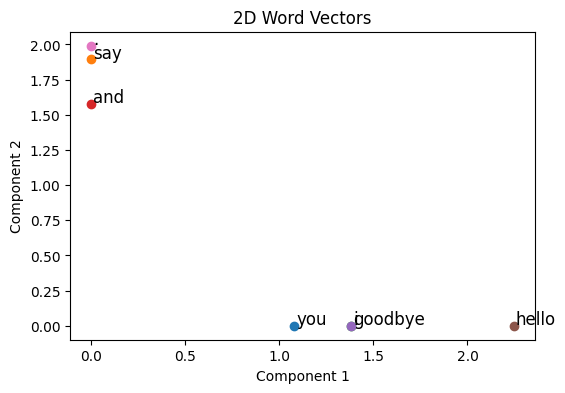

In [16]:
plt.figure(figsize = (6, 4))
for i, word in id_to_word.items():
  plt.scatter(word_vectors[i, 0], word_vectors[i, 1])
  plt.text(word_vectors[i, 0]+0.01, word_vectors[i, 1]+0.01, word, fontsize=12)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('2D Word Vectors')
plt.show()

In [18]:
def load_text(filepath):
  with open(filepath, 'r', encoding='utf-8') as f:
    return f.read()

In [19]:
text = load_text('/content/drive/MyDrive/2025_1_Colab/DeepLearning/Lib/NLP/text.txt')

In [22]:
import re
def preprocess(text):
  text = text.lower()
  # 괄호, 쉼표, 마침표 등 구두점 제거
  text = re.sub(r'[^\w\s]', '', text)
  # 줄바꿈 제거
  text = text.replace('\n', ' ')
  words = text.split(' ')
  word_to_id = {}
  id_to_word = {}

  for word in words:
    if word not in word_to_id:
      new_id = len(word_to_id)
      word_to_id[word] = new_id
      id_to_word[new_id] = word

  corpus = [word_to_id[word] for word in words]
  return corpus, word_to_id, id_to_word

In [23]:
corpus, word_to_id, id_to_word = preprocess(text)

co_matrix = create_co_matrix(corpus, 2)
words = [id_to_word[i] for i in range(len(id_to_word))]
df_co_matrix = pd.DataFrame(co_matrix, index=words, columns = words)

PPMI = compute_ppmi_martix(co_matrix)

svd = TruncatedSVD(n_components=2)
word_vectors = svd.fit_transform(PPMI)

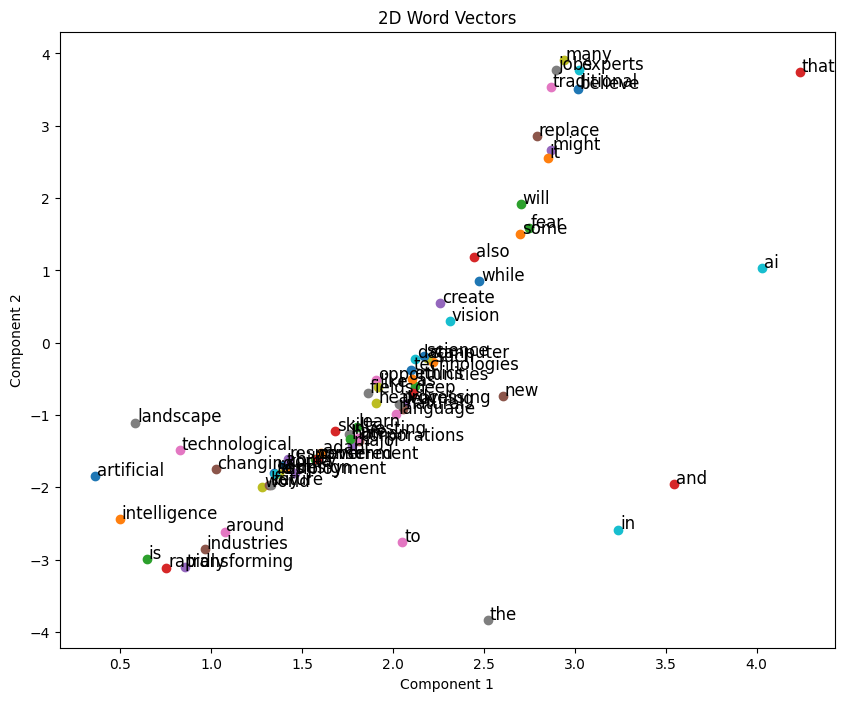

In [24]:
plt.figure(figsize=(10, 8))
for i, word in id_to_word.items():
  plt.scatter(word_vectors[i, 0], word_vectors[i, 1])
  plt.text(word_vectors[i, 0]+0.01, word_vectors[i, 1]+0.01, word, fontsize=12)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('2D Word Vectors')
plt.show()